## Volatility Modeling with GARCH: Predicting Stock Market Fluctuations

### <b>Introduction</b>

Stock market volatility is a key factor that investors analyze when making decisions. Understanding and predicting volatility can help manage risk and optimize investment strategies. In this project, we develop a **Generalized Autoregressive Conditional Heteroskedasticity (`GARCH`) model** to forecast stock price volatility, specifically focusing on **Ambuja** and **Suzlon stocks**.

To achieve this, we:  
✅ **Wrangle data** by calculating stock returns.  
✅ **Explore volatility patterns** for Ambuja and Suzlon stocks.  
✅ **Build a GARCH model** to predict future volatility for Ambuja stock.  
✅ **Format predictions** for clear and actionable insights.  

Additionally, we implement **assert statements** to ensure code reliability and accuracy. The outcome will provide stakeholders with a structured approach to volatility modeling, enhancing decision-making in financial markets.

In [4]:
#Install the arch package in Jupyter Notebook
#!pip install arch

In [1]:
# Import required libraries
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from arch import arch_model
from config import settings
from data import SQLRepository
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## <b>Prepare Data</b>
### <b>Establishing a Reliable Foundation</b>

Before making any predictions, we must first **connect to our data source and prepare the dataset** for analysis. This step ensures that our data is clean, structured, and ready for modeling.

By wrangling the data efficiently, we can extract meaningful insights and enhance the accuracy of our **volatility predictions**. Establishing **a reliable data pipeline** is crucial for making informed, data-driven investment decisions.

### <b>Import</b>

NB: The database (`stocks.sqlite`) and the supporting modules (`data.py` and `config.py`) are sourced from the GitHub project repository **"Test Driven Development with AlphaVantageAPI and SQLRepository."**

**Connect to Database**  
Create a connection to the database and then instantiate a `SQLRepository` named `repo` to interact with that database.

In [2]:
connection = sqlite3.connect(settings.db_name, check_same_thread=False)
repo = SQLRepository(connection= connection)

Now that we're connected to a database, With the database connection established, we can now retrieve the necessary data.

**Read Ambuja Data From Database**  
Retrieve the most recent (latest) 2,500 rows of data for **Ambuja Cement** from the database and store the results in the variable `df_ambuja`.

df_ambuja = repo.read_table(table_name="AMBUJACEM.BSE", limit=2500)

print("df_ambuja shape:", df_ambuja.shape)
df_ambuja.head()


To train our model, we only need the **daily returns** for **"AMBUJACEM.BSE"**. While we previously learned how to calculate returns, we will now **formalize the process** by creating a dedicated `wrangle_data` function. This function will streamline data preparation, ensuring consistency and efficiency in our analysis.

**Wrangle_data Function**  
Create a `wrangle_data` function to extract stock data from the database and compute returns.

**Parameters**:  
    -**ticker (str)**: Stock ticker (also table name in the database).  
    -**n_observations (int)**: Number of rows to retrieve.  
**Returns**:  
    -**pd.Series**: A series of stock returns (no `NaN` values) named `"return"`.  

In [4]:
def wrangle_data(ticker, n_observations):

    # Get table from database
    df= repo.read_table(table_name=ticker, limit= n_observations +1)

    # Sort DataFrame ascending by date
    df.sort_index(ascending=True, inplace=True)

    # Create "return" column
    df["return"]= df["close"].pct_change() * 100

    # Return returns
    return df["return"].dropna()

To validate your `wrangle_data` function, you can use **assert statements** to ensure that the output meets the expected conditions. These assertions typically check that the returned data is in the correct format and meets specific criteria, like being a `pd.Series` and having no `NaN` values.

In [5]:
y_ambuja = wrangle_data(ticker="AMBUJACEM.BSE", n_observations=2500)

# Is `y_ambuja` a Series?
assert isinstance(y_ambuja, pd.Series)

# Are there 2500 observations in the Series?
assert len(y_ambuja) == 2500

# Is `y_ambuja` name "return"?
assert y_ambuja.name == "return"

# Does `y_ambuja` have a DatetimeIndex?
assert isinstance(y_ambuja.index, pd.DatetimeIndex)

# Is index sorted ascending?
assert all(y_ambuja.index == y_ambuja.sort_index(ascending=True).index)

# Are there no `NaN` values?
assert y_ambuja.isnull().sum() == 0

y_ambuja.head()

date
2014-12-03    0.393787
2014-12-04    0.217912
2014-12-05    3.044140
2014-12-08   -2.405571
2014-12-09   -2.248649
Name: return, dtype: float64

Great work! Now that we've got a wrangle function, let's get the returns for Suzlon Energy, too.

**Read Suzlon Data From Database**  
Use your `wrangle_data` function to get the returns for the 2,500 most recent trading days of Suzlon Energy. Assign the results to `y_suzlon`.

In [6]:
y_suzlon = wrangle_data(ticker="SUZLON.BSE", n_observations=2500)

print("y_suzlon shape:", y_suzlon.shape)
y_suzlon.head()

y_suzlon shape: (2500,)


date
2014-12-15   -1.498127
2014-12-16   -1.673004
2014-12-17   -3.480278
2014-12-18    4.006410
2014-12-19   -1.617874
Name: return, dtype: float64

### <b>Explore</b>

Let's create the volatility time series plot so that we have a visual aid to to visually demonstrate what volatility is.

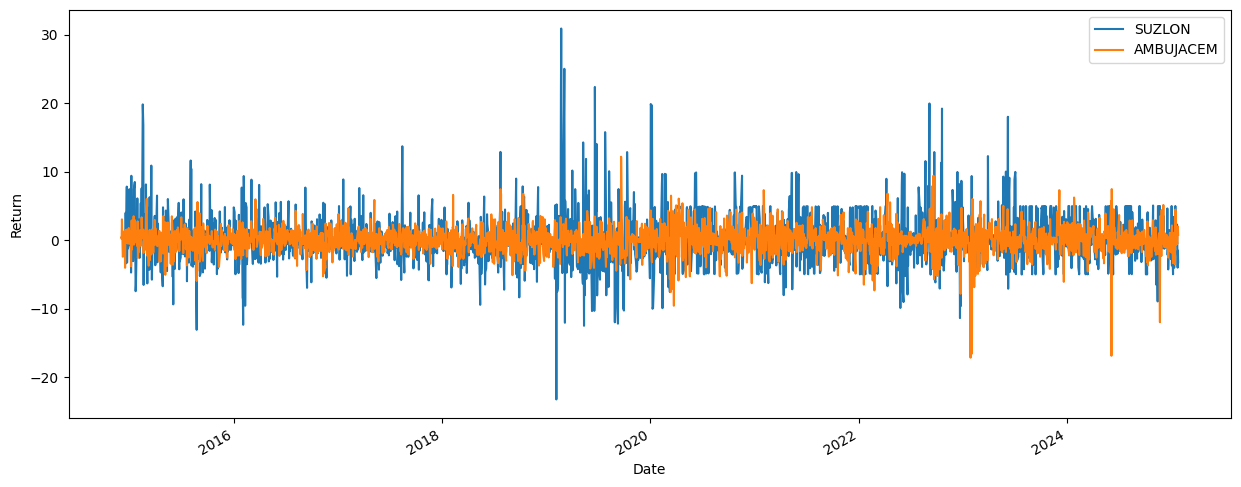

In [7]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for `df_suzlon` and `df_ambuja`
y_suzlon.plot(ax=ax, label="SUZLON")
y_ambuja.plot(ax=ax, label="AMBUJACEM")

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")

# Add legend
plt.legend();

The above plot shows how returns change over time. This may seem like a totally new concept, but if we visualize them without considering time, things will start to look familiar.

**Conditional vs Unconditional volatility**  
Create a histogram `y_ambuja` with 25 bins. Be sure to label the x-axis `"Returns"`, the y-axis `"Frequency [count]"`, and use the title `"Distribution of Ambuja Cement Daily Returns"`.

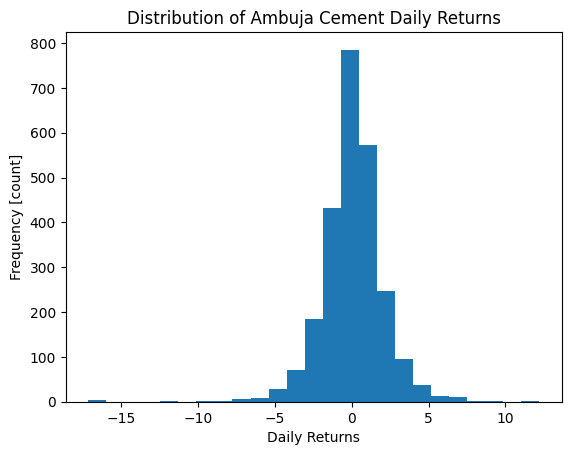

In [8]:
# Create histogram of `y_ambuja`, 25 bins
plt.hist(y_ambuja, bins=25)

# Add axis labels
plt.xlabel("Daily Returns")
plt.ylabel("Frequency [count]")

# Add title
plt.title("Distribution of Ambuja Cement Daily Returns");

This is a familiar shape! It turns out that returns follow an almost normal distribution, centered on `0`. **Volatility** is the measure of the spread of these returns around the mean. In other words, volatility in finance is the same thing at standard deviation in statistics.

Let's start by measuring the daily volatility of our two stocks. Since our data frequency is also daily, this will be exactly the same as calculating the standard deviation.

**Daily Volatility Calculations**  
The daily volatility for Suzlon and Ambuja is calculated and represented by the variables **suzlon_daily_volatility** and **ambuja_daily_volatility**, respectively.

In [9]:
suzlon_daily_volatility = y_suzlon.std()
ambuja_daily_volatility = y_ambuja.std()

print("Suzlon Daily Volatility:", suzlon_daily_volatility)
print("Ambuja Daily Volatility:", ambuja_daily_volatility)

Suzlon Daily Volatility: 3.7651057704470174
Ambuja Daily Volatility: 1.9959110727839469


Looks like Suzlon is more volatile than Ambuja. This reinforces what we saw in our time series plot, where Suzlon returns have a much wider spread.

While daily volatility is useful, investors are also interested in volatility over other time periods — like annual volatility. Keep in mind that a year isn't 365 days for a stock market, though. After excluding weekends and holidays, most markets have only 252 trading days.

**The Annual Volatility Calculations**  
The annual volatility determinations for Suzlon and Ambuja, assigning the results to `suzlon_annual_volatility` and `ambuja_annual_volatility`, respectively.

In [10]:
suzlon_annual_volatility = suzlon_daily_volatility * np.sqrt(252)
ambuja_annual_volatility = ambuja_daily_volatility * np.sqrt(252)

print("Suzlon Annual Volatility:", suzlon_annual_volatility)
print("Ambuja Annual Volatility:", ambuja_annual_volatility)

Suzlon Annual Volatility: 59.76920117074231
Ambuja Annual Volatility: 31.684106025518766


Again, Suzlon has higher volatility than Ambuja. What do you think it means that the annual volatility is larger than daily?

Since we're dealing with time series data, another way to look at volatility is by calculating it using a rolling window. Here, we'll start focusing on Ambuja Cement exclusively.

**Calculate Rolling Volatility**  
Calculate the rolling volatility for `y_ambuja`, using a 50-day window. Assign the result to `ambuja_rolling_50d_volatility`.

In [11]:
ambuja_rolling_50d_volatility = y_ambuja.rolling(window=50).std().dropna()

print("rolling_50d_volatility shape:", ambuja_rolling_50d_volatility.shape)
ambuja_rolling_50d_volatility.head()

rolling_50d_volatility shape: (2451,)


date
2015-02-12    1.684393
2015-02-13    1.701390
2015-02-16    1.701359
2015-02-18    1.664853
2015-02-19    1.648045
Name: return, dtype: float64

**Plot Rolling Volatility**  
Let's create a time series plot showing the daily returns for Ambuja Cement and the 50-day rolling volatility.

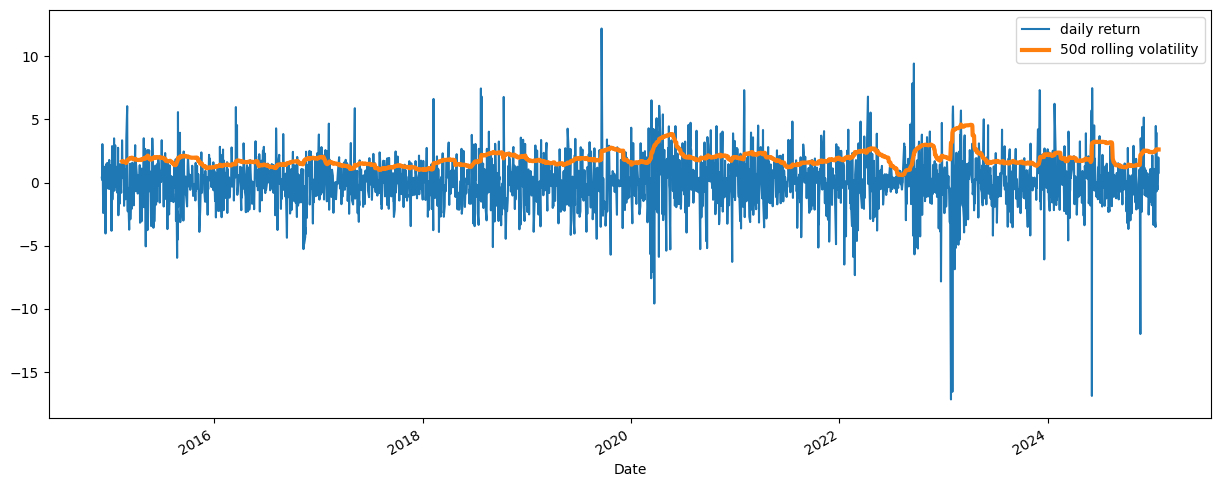

In [12]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `y_ambuja`
y_ambuja.plot(ax=ax, label="daily return")

# Plot `ambuja_rolling_50d_volatility`
ambuja_rolling_50d_volatility.plot(ax=ax, label="50d rolling volatility", linewidth=3)

# Add x-axis label
plt.xlabel("Date")

# Add legend
plt.legend();

Here we can see that volatility goes up when the returns change drastically — either up or down. For instance, we can see a big increase in volatility in May 2020, when there were several days of large negative returns. We can also see volatility go down in August 2022, when there are only small day-to-day changes in returns.

This plot reveals a problem. We want to use returns to see if high volatility on one day is associated with high volatility on the following day. But high volatility is caused by large changes in returns, which can be either positive or negative. How can we assess negative and positive numbers together without them canceling each other out? One solution is to take the absolute value of the numbers, which is what we do to calculate performance metrics like mean absolute error. The other solution, which is more common in this context, is to square all the values.  

**Plot Squared Returns**  
Let's create a time series plot of the squared returns in `y_ambuja`.

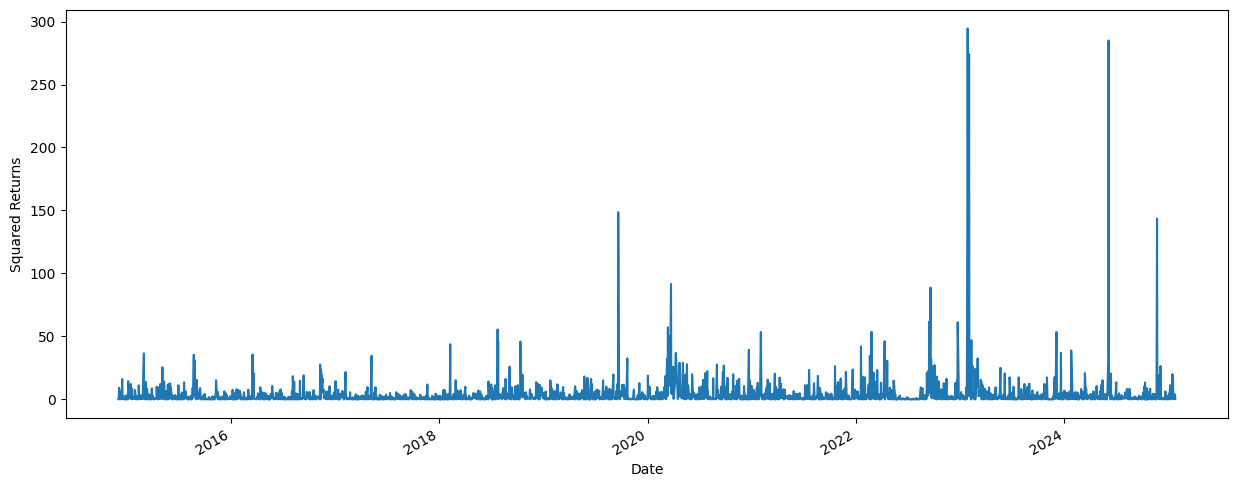

In [13]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot squared returns
(y_ambuja ** 2).plot(ax=ax)

# Add axis labels
plt.xlabel("Date")
plt.ylabel("Squared Returns");

Perfect! Now it's much easier to see that:  
    (1) we have periods of high and low volatility, and  
    (2) high volatility days tend to cluster together.
        
This is a perfect situation to use a GARCH model.

A GARCH model is sort of like the ARMA model. It has a `p` parameter handling correlations at prior time steps and a `q` parameter for dealing with "shock" events. It also uses the notion of lag. To see how many lags we should have in our model, we should create an **ACF** and **PACF plot** — but using the squared returns. 

**ACF of Squared Returns**  
Let's create an ACF plot of squared returns for Ambuja Cement, and labelling your x-axis `"Lag [days]"` and your y-axis `"Correlation Coefficient"`.

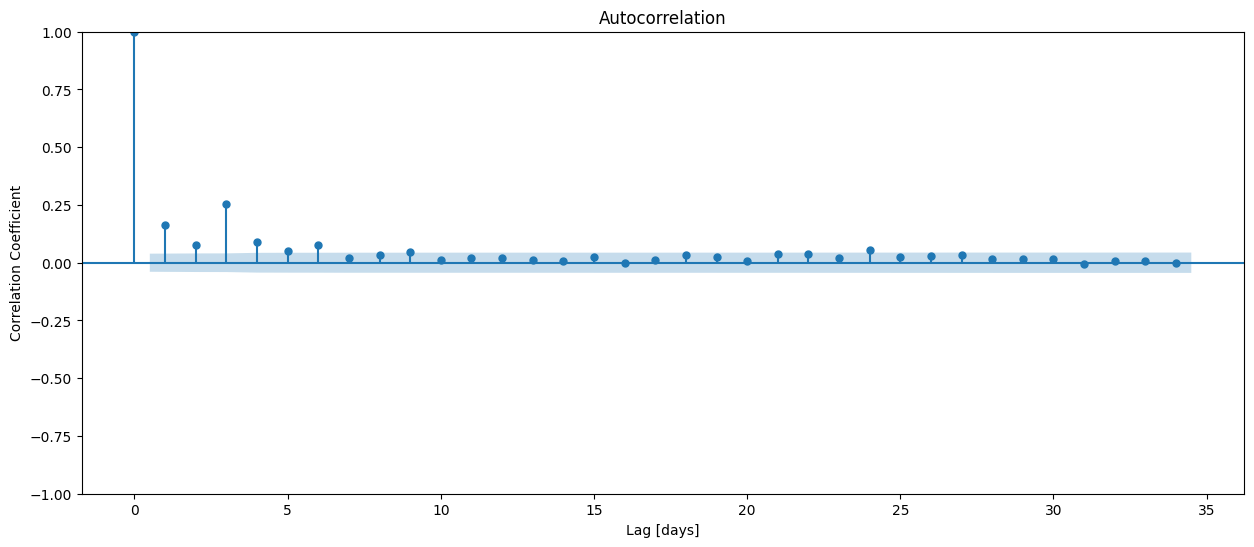

In [14]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared returns
plot_acf(y_ambuja**2, ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");

**PACF of Squared Returns**  
Let's also create a PACF plot of squared returns for Ambuja Cement,and again by labelling your x-axis `"Lag [days]"` and your y-axis `"Correlation Coefficient"`.

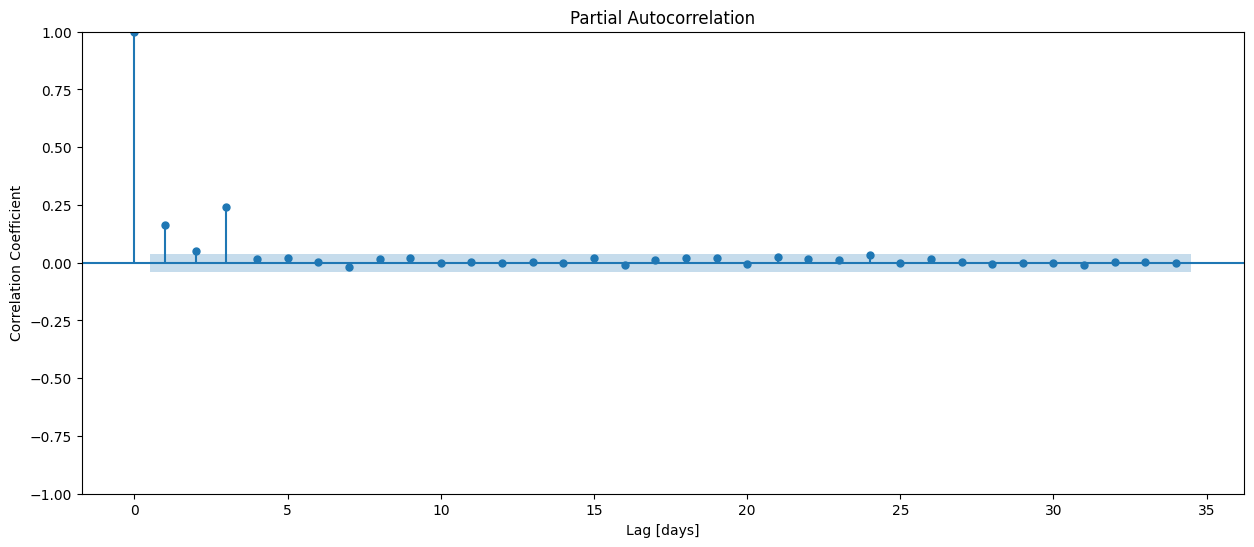

In [15]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create PACF of squared returns
plot_pacf(y_ambuja**2, ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");

In our PACF, it looks like a lag of 3 would be a good starting point. 

Normally, at this point in the model building process, we would split our data into training and test sets, and then set a baseline. Not this time. This is because our model's input and its output are two different measurements. We'll use **returns** to train our model, but we want it to predict **volatility**. If we created a test set, it wouldn't give us the "true values" that we'd need to assess our model's performance. So this time, we'll skip right to iterating. 

### Split

The last thing we need to do before building our model is to create a training set. Note that we won't create a test set here. Rather, we'll use all of `y_ambuja` to conduct walk-forward validation after we've built our model. 

**Split Ambuja Data**  
Create a training set `y_ambuja_train` that contains the first 80% of the observations in `y_ambuja`.

In [16]:
cutoff_test = int(len(y_ambuja) * 0.8)
y_ambuja_train = y_ambuja.iloc[:cutoff_test]

print("y_ambuja_train shape:", y_ambuja_train.shape)
y_ambuja_train.tail()

y_ambuja_train shape: (2000,)


date
2023-01-05    1.204703
2023-01-06   -0.999905
2023-01-09    0.933051
2023-01-10   -1.896502
2023-01-11   -1.282300
Name: return, dtype: float64

## <b>Build Model</b>
We will begin by iterating, similar to the approach used in similar models.

### <b>Iterate</b>

**Build GARCH Model**  
Let's build and fit a GARCH model using the data in `y_ambuja`, and start with `3` as the value for `p` and `q`. Then use the model summary to assess its performance and try other lags.

In [19]:
# Build and train model
model = arch_model(y_ambuja_train, p=1, q=1, rescale=False).fit(disp=0)

# Show model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4010.00
Distribution:                  Normal   AIC:                           8028.01
Method:            Maximum Likelihood   BIC:                           8050.41
                                        No. Observations:                 2000
Date:                Thu, Jan 30 2025   Df Residuals:                     1999
Time:                        13:16:56   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0711  3.831e-02      1.856  6.350e-02 [-3.995e-03,  0.146]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1743  6.169e-02      2.826  4.711e-03 [5.343e-02,  0.295]
alpha[1]       0.0868  1.823e-02      4.760  1.935e-06 [5.106e-02,  0.123]
beta[1]        0.8653  2.783e-02     31.086 3.710e-212   [  0.811,  0.920]
==========================================================================

Covariance estimator: robust
"""

In [20]:
model.aic

8028.0075017603085

In [21]:
model.bic

np.float64(8050.411111598477)

Now that we've settled on a model, let's visualize its predictions, together with the Ambuja returns.

**Plot Returns vs Predictions**  
Let's create a time series plot with the Ambuja returns and the conditional volatility for our model.

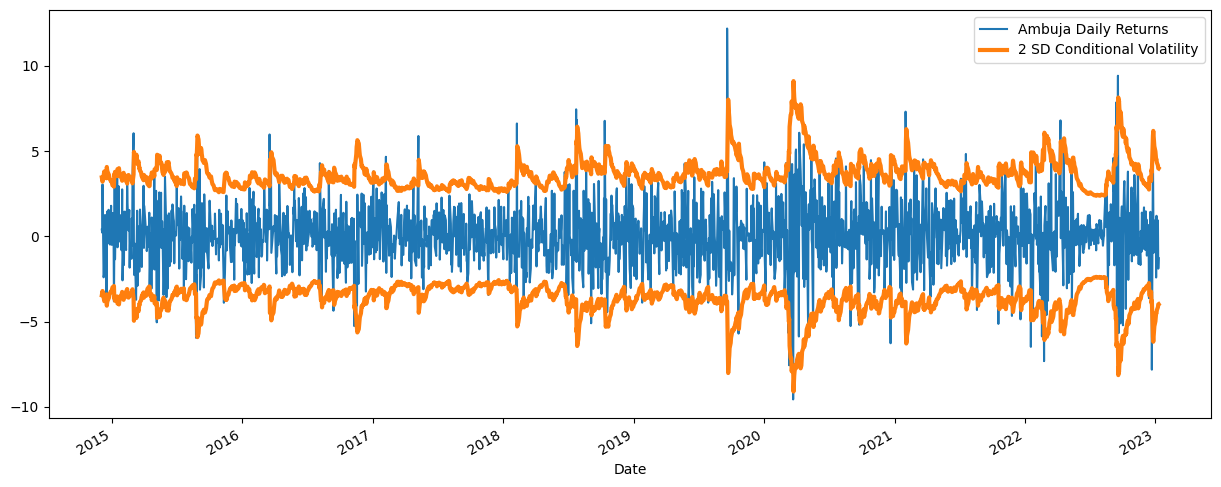

In [23]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `y_ambuja_train`
y_ambuja_train.plot(ax=ax, label="Ambuja Daily Returns")

# Plot conditional volatility * 2
(2 * model.conditional_volatility).plot(
    ax=ax, color="C1", label="2 SD Conditional Volatility", linewidth=3
)

# Plot conditional volatility * -2
(- 2 * model.conditional_volatility.rename("")).plot(
    ax=ax, color="C1", linewidth=3
)

# Add axis labels
plt.xlabel("Date")

# Add legend
plt.legend();

Visually, our model looks pretty good, but we should examine residuals, just to make sure. In the case of GARCH models, we need to look at the standardized residuals.

**Plot Standardized Residuals**  
Create a time series plot of the standardized residuals for your `model`.

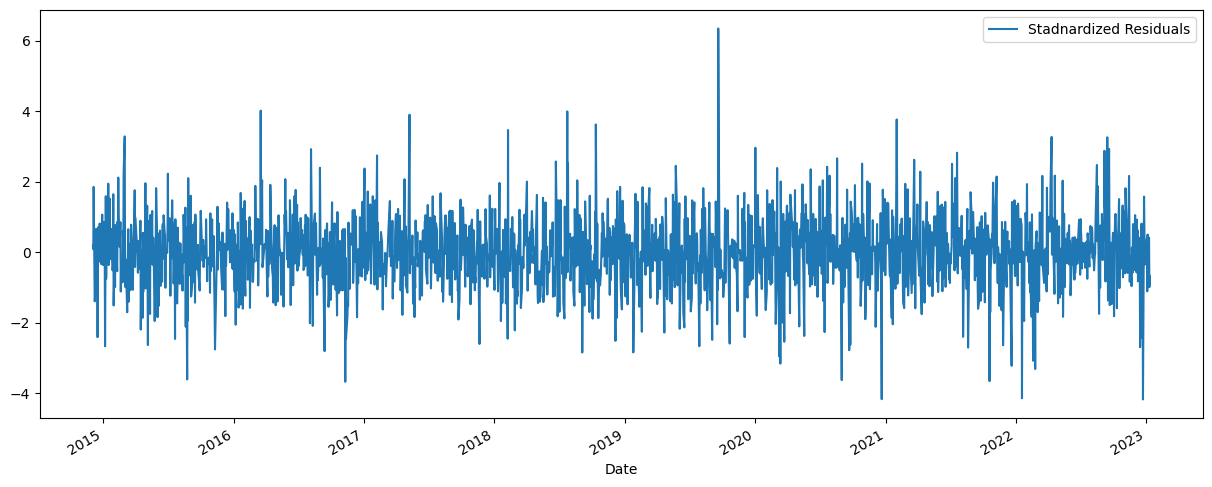

In [24]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot standardized residuals
model.std_resid.plot(ax=ax, label="Stadnardized Residuals")

# Add axis labels
plt.xlabel("Date")

# Add legend
plt.legend();

These residuals look good: they have a consistent mean and spread over time. Let's check their normality using a histogram.

**Histogram of Standardized Residuals**  
Le's create a histogram with 25 bins of the standardized residuals for your model.

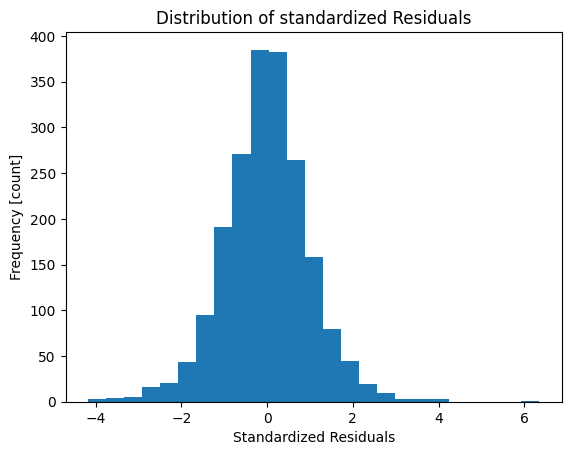

In [25]:
plt.hist(model.std_resid, bins=25)

# Add axis labels
plt.xlabel("Standardized Residuals")
plt.ylabel("Frequency [count]")

# Add title
plt.title("Distribution of standardized Residuals");

Our last visualization will the ACF of standardized residuals. Just like we did with our first ACF, we'll need to square the values here, too.

**ACF of Standardized Residuals**  
Let's reate an ACF plot of the square of your standardized residuals. 

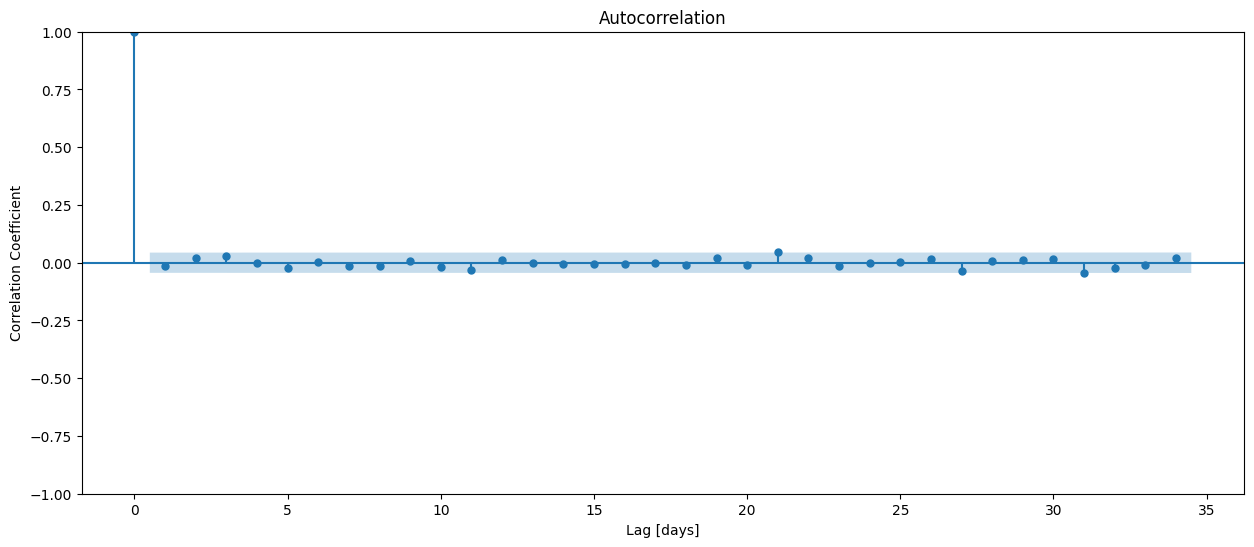

In [26]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared, standardized residuals
plot_acf(model.std_resid **2, ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");

Excellent! Looks like this model is ready for a final evaluation.

## <b>Evaluate</b>

To evaluate our model, we'll do walk-forward validation. Before we do, let's take a look at how this model returns its predictions.

**One-Day Forecast**  
Let's create a one-day forecast from your `model` and assign the result to the variable `one_day_forecast`. 

In [27]:
one_day_forecast = model.forecast(horizon=1, reindex=False).variance

one_day_forecast

,h.1
date,
2023-01-11,3.75872


There are two things we need to keep in mind here. First, our `model` forecast shows the predicted **variance**, not the **standard deviation** / **volatility**. So we'll need to take the square root of the value. Second, the prediction is in the form of a DataFrame. It has a DatetimeIndex, and the date is the last day for which we have training data. The `"h.1"` column stands for "horizon 1", that is, our model's prediction for the following day. We'll have to keep all this in mind when we reformat this prediction to serve to the end user of our application.

**Walk-Forward Validation**  
Let's complete the code below to do walk-forward validation on your `model`, and then run the following code block to visualize the model's test predictions.

In [28]:
# Create empty list to hold predictions
predictions = []

# Calculate size of test data (20%)
test_size = int(len(y_ambuja) * 0.2)

# Walk forward
for i in range(test_size):
    # Create test data
    y_train = y_ambuja.iloc[: -(test_size - i)]

    # Train model
    model = arch_model(y_train, p=1, rescale=False).fit(disp=0)

    # Generate next prediction (volatility, not variance)
    next_pred = model.forecast(horizon=1, reindex=False).variance.iloc[0,0] **0.5

    # Append prediction to list
    predictions.append(next_pred)

# Create Series from predictions list
y_test_wfv = pd.Series(predictions, index=y_ambuja.tail(test_size).index)

print("y_test_wfv shape:", y_test_wfv.shape)
y_test_wfv.head()

y_test_wfv shape: (500,)


date
2023-01-12    1.938742
2023-01-13    1.852316
2023-01-16    1.830412
2023-01-17    1.756814
2023-01-18    1.683841
dtype: float64

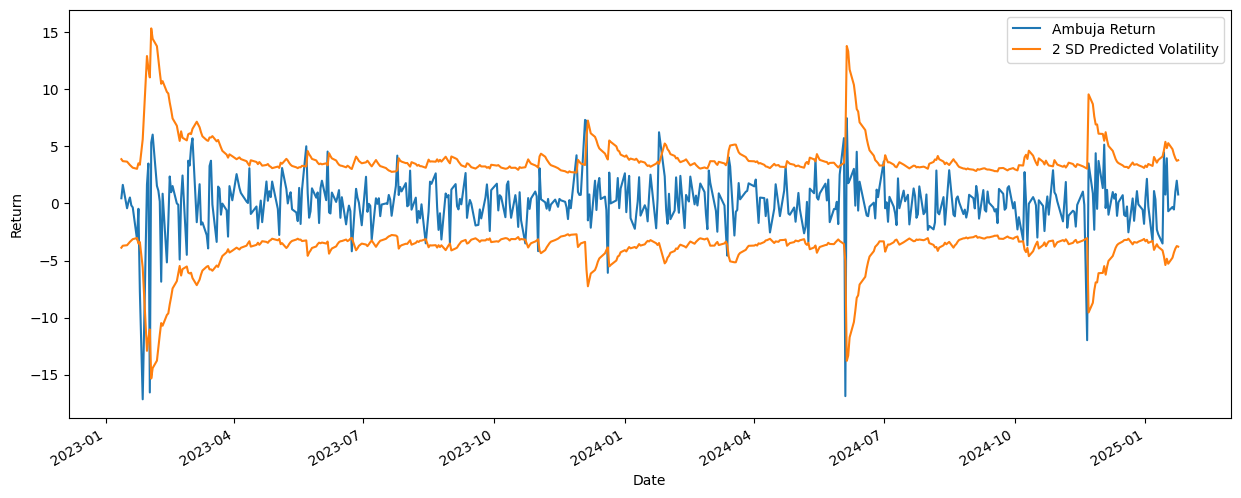

In [29]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for test data
y_ambuja.tail(test_size).plot(ax=ax, label="Ambuja Return")

# Plot volatility predictions * 2
(2 * y_test_wfv).plot(ax=ax, c="C1", label="2 SD Predicted Volatility")

# Plot volatility predictions * -2
(-2 * y_test_wfv).plot(ax=ax, c="C1")

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")

# Add legend
plt.legend();

This looks pretty good. Our volatility predictions seem to follow the changes in returns over time. This is especially clear in the low-volatility period in the summer of 2022 and the high-volatility period in fall 2022.

One additional step we could do to evaluate how our `model` performs on the test data would be to plot the ACF of the standardized residuals for only the test set.

## <b>Communicate Results</b>

Normally in this section, we create visualizations for a human audience, but our goal for *this* project is to create an API for a *computer* audience. So we'll focus on transforming our model's predictions to JSON format, which is what we'll use to send predictions in our application. 

The first thing we need to do is create a DatetimeIndex for our predictions. Using labels like `"h.1"`, `"h.2"`, etc., won't work. But there are two things we need to keep in mind. First, we can't include dates that are weekends because no trading happens on those days. And we'll need to write our dates using strings that follow the [ISO 8601](https://en.wikipedia.org/wiki/ISO_8601) standard. 

**Format Timestamps**  
Below is a `prediction`, which contains a 5-day forecast from our `model`. Using it as a starting point, create a `prediction_index`. This should be a list with the following 5 dates written in ISO 8601 format.

In [30]:
# Generate 5-day volatility forecast
prediction = model.forecast(horizon=5, reindex=False).variance ** 0.5
print(prediction)

# Calculate forecast start date
start = prediction.index[0] + pd.DateOffset(days=1)

# Create date range
prediction_dates = pd.bdate_range(start=start, periods= prediction.shape[1])

# Create prediction index labels, ISO 8601 format
prediction_index = [d.isoformat() for d in prediction_dates]

print("prediction_index type:", type(prediction_index))
print("prediction_index len:", len(prediction_index))
prediction_index[:3]

                 h.1       h.2      h.3       h.4       h.5
date                                                       
2025-01-23  1.892763  1.905151  1.91584  1.925071  1.933048
prediction_index type: <class 'list'>
prediction_index len: 5


['2025-01-24T00:00:00', '2025-01-27T00:00:00', '2025-01-28T00:00:00']

Now that we know how to create the index, let's create a function to combine the index and predictions, and then return a dictionary where each key is a date and each value is a predicted volatility.

**Clean_Prediction Function**  
We will create a `clean_prediction` function that takes a variance prediction DataFrame as input and returns a dictionary. The dictionary will map each date (in ISO 8601 format) to the corresponding predicted volatility, based on the variance from an `ARCHModelForecast`.

In [31]:
def clean_prediction(prediction):

    # Calculate forecast start date
    start = prediction.index[0] + pd.DateOffset(days=1)

    # Create date range
    prediction_dates = pd.bdate_range(start=start, periods=prediction.shape[1])

    # Create prediction index labels, ISO 8601 format
    prediction_index = [d.isoformat() for d in prediction_dates]

    # Extract predictions from DataFrame, get square root
    data = prediction.values.flatten() ** 0.5

    # Combine `data` and `prediction_index` into Series
    prediction_formatted = pd.Series(data, index=prediction_index)

    # Return Series as dictionary
    return prediction_formatted.to_dict()


In [32]:
prediction = model.forecast(horizon=10, reindex=False).variance
prediction_formatted = clean_prediction(prediction)

# Is `prediction_formatted` a dictionary?
assert isinstance(prediction_formatted, dict)

# Are keys correct data type?
assert all(isinstance(k, str) for k in prediction_formatted.keys())

# Are values correct data type
assert all(isinstance(v, float) for v in prediction_formatted.values())

prediction_formatted

{'2025-01-24T00:00:00': 1.8927626545088698,
 '2025-01-27T00:00:00': 1.9051513297448672,
 '2025-01-28T00:00:00': 1.9158404611980442,
 '2025-01-29T00:00:00': 1.9250711209452231,
 '2025-01-30T00:00:00': 1.933048127253041,
 '2025-01-31T00:00:00': 1.9399460332242837,
 '2025-02-03T00:00:00': 1.9459139875393232,
 '2025-02-04T00:00:00': 1.951079714743828,
 '2025-02-05T00:00:00': 1.9555527996452424,
 '2025-02-06T00:00:00': 1.9594274155772011}

In [ ]:
Great work! We now have several components for our application: classes for getting data from an API, classes for storing it in a database, and code for building our model and cleaning our predictions. The next step is creating a class for our model and paths for application — both of which we'll do in the next lesson.